# Defining Domains: The New @ Syntax 

The latest version of OpenPNM includes a new syntax feature with several uses. This notebooks outlines benefits of this new feature, starting with the superficial or immediately visible aspects, then dives into the underlying impacts.

## Using the @ sytax to read and write data
At its core, the @ syntax uses the already existing *labels* feature of OpenPNM.  Labels have been integral to the use of OpenPNM since its inception, but the new @ syntax moves the use of labels to forefront. 

Start by generating a simple 2D cubic network:

In [1]:
import numpy as np
import openpnm as op
pn = op.network.Cubic([2, 4, 1])
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x23b54e3d130>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         8 / 8
  2  throat.conns                                                      10 / 10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                               2
  2  pore.front                                                              2
  3  pore.left                                                               4
  4 

This network includes a few pre-defined labels (e.g. ``'pore.left'`` and ``'throat.surface'``), which are boolean masks of ``True|False`` values which indicate whether that label applies to a given pore/throat or not.  As shown below, the label ``'pore.left'`` applies to pores ``[0, 1, 2, 3]``:

In [2]:
print(pn['pore.left'])

[ True  True  True  True False False False False]


We can use labels as masks to view only values for given locations, as follows:

In [3]:
pn['pore.coords'][pn['pore.left']]

array([[0.5, 0.5, 0.5],
       [0.5, 1.5, 0.5],
       [0.5, 2.5, 0.5],
       [0.5, 3.5, 0.5]])

or using the ``pores`` method:

In [4]:
pn['pore.coords'][pn.pores('left')]

array([[0.5, 0.5, 0.5],
       [0.5, 1.5, 0.5],
       [0.5, 2.5, 0.5],
       [0.5, 3.5, 0.5]])

In OpenPNM V3 there is a very handy new syntax, **the @ symbol**,  used as follows:

In [5]:
pn['pore.coords@left']

array([[0.5, 0.5, 0.5],
       [0.5, 1.5, 0.5],
       [0.5, 2.5, 0.5],
       [0.5, 3.5, 0.5]])

This certainly saves some typing!  It's also pretty intuitive since ``@`` is usually read as "at", inferring a location. 

The @ sytax can also be used to write data as well. Let's create an array of 1.0s, then use the @ syntax to change them:

In [6]:
pn['pore.values'] = 1.0

If we supply a scalar, it is written to all locations belong to ``'left'``:

In [7]:
pn['pore.values@left'] = 2.0
print(pn['pore.values'])

[2. 2. 2. 2. 1. 1. 1. 1.]


We can of course pass in an array, which must have the correct number of elements:

In [8]:
pn['pore.values@right'] = [4, 5, 6, 7]
print(pn['pore.values'])

[2. 2. 2. 2. 4. 5. 6. 7.]


One useful bonus is that you can create an array and assign values to certain locations at the same time:

In [9]:
pn['pore.new_array@left'] = 2.0
print(pn['pore.new_array'])

[ 2.  2.  2.  2. nan nan nan nan]


The above line created an empty array of ``nans``, then added ``2.0`` to the pores labelled ``'left'``.  This was not previously possible without first creating an empty array before adding ``2.0`` to specific locations.

You can use any label that is defined, and it will overwrite any values already present if that label happens to overlap the label used previously:

In [10]:
pn['pore.new_array@front'] = 3.0
print(pn['pore.new_array'])

[ 3.  2.  2.  2.  3. nan nan nan]


which overwrote some locations that had ``2.0``, since some pores are both ``'front'`` and ``'left'``, as well as overwrote some of the ``nan`` values.

In [11]:
print(pn['pore.new_array@left'])

[3. 2. 2. 2.]


## Using the @ Syntax to Define Subdomains

Using the @ symbol for data read/write as shown above is actually a side effect of a *major conceptual shift* made in V3. The ``Geometry`` and ``Physics`` objects are now *gone*.  There was essentially only one use case for these, which was to model heterogeneous domains, like bimodal pore size distributions or layered structures.  

In V2 this was accomplished by using 2 (or more) ``Geometry`` objects to represent each class of pores, with unique pore-scale models attached to each.  Without getting lost in the details, it is sufficient to say that having separate objects for managing each class of pores (and/or throats) created a *lot* of complications, both to the user and to the maintenence of the backend.  

In V3 we have developed what we think is a *much tidier approach* to managing heterogeneous domains.  Instead of creating multiple ``Geometry`` objects (and consequently multiple ``Physics`` objects), you now add all the pore-scale models to the ``Network`` and ``Phase`` objects directly.  The trick is that when adding models you specify one additional argument: the  ``domain`` (i.e. pores or throats) to which the model applies, as follows:

In [12]:
pn.add_model(propname='pore.seed', 
             model=op.models.geometry.pore_seed.random,
             domain='left',
             seed=0,
             num_range=[0.1, 0.5])

where ``domain`` is given the label ``'left'`` which has already been defined on the network. 

This means that to create a heterogeneous model you only need to create labels marking the pores and/or throats of each domain, then pass those labels when adding models. You can also leave ``domain`` unspecified (``None``) which means the model is applied everywhere. For the above case, we can see that the ``'pore.seed'`` model was computed for 4 locations (corresponding the 4 pores labelled ``'left'``):

In [13]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x23b54e3d130>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         8 / 8
  2  pore.new_array                                                      5 / 8
  3  pore.seed                                                           4 / 8
  4  pore.values                                                         8 / 8
  5  throat.conns                                                      10 / 10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1 

The power of this new approach is really visible when we consider applying a model with different parameters to a different set of pores:

In [14]:
pn.add_model(propname='pore.seed', 
             model=op.models.geometry.pore_seed.random,
             domain='right',
             seed=0,
             num_range=[0.5, 0.9])

Now the ``pore.seed'`` values exist on 8 locations.

In [15]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x23b54e3d130>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         8 / 8
  2  pore.new_array                                                      5 / 8
  3  pore.seed                                                           8 / 8
  4  pore.values                                                         8 / 8
  5  throat.conns                                                      10 / 10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1 

The new approach was made possible by changing how pore-scale models are stored on objects.  Each object has a ``models`` attribute, which is a ``dict`` where the ``key`` corresponds to the property being calculated.  So the values stored in ``pn['pore.seed']`` are computed by the model stored as ``pn.models['pore.seed']``.  The new ``@`` notation makes it possible to store multiple models for ``'pore.seed'`` that apply to different location on the same object.  This can be seen below by printing the models attribute:

In [16]:
print(pn.models)

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#   Property Name                       Parameter                 Value
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1   pore.coordination_number@all        model:                    coordination_number
                                        regeneration mode:        deferred
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2   throat.spacing@all                  model:                    pore_to_pore_distance
                                        regeneration mode:        deferred
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
3   pore.seed@left                      model:                    random
                                        seed:                     0
                                        num_range:                [0.1, 0.5]
                                        re

Appending ``@`` to the model name creates a unique dictionary key. OpenPNM recoginizes that the models in ``'pore.seed@left'`` and ``'pore.seed@right'`` both compute values of ``'pore.seed'``, and directs the outputs of each function to the correct locations, which it can infer from the ``@right/left`` portion of the key.

## Other Advantages of the @ Syntax
There are many upsides to this approach, as will be demonstrated in the following sections.

### Defining and Changing Subdomain Locations
It becomes trivial to define and redefine the locations of a domain.  This simply requires changing where ``pn['pore.left']`` is ``True``.  This is demonstrated as follows:

In [17]:
pn.pores('left')

array([0, 1, 2, 3])

In [18]:
pn['pore.left'][[4, 5]] = True
del pn['pore.seed']

In [19]:
pn.run_model('pore.seed@left')
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x23b54e3d130>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         8 / 8
  2  pore.new_array                                                      5 / 8
  3  pore.seed                                                           6 / 8
  4  pore.values                                                         8 / 8
  5  throat.conns                                                      10 / 10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1 

It can now been observed that ``'pore.seed'`` values are found in 6 locations because the domain labelled ``'left'`` was expanded by 2 pores. 

### Mixing Full Domain and Subdomain Models
When defining two separate subdomains, the pore and throat sizes are often the only thing that is different.  In V2, however, it was recommended practice to include ALL the additional models on each subdomain object as well, such as volume calculations.  With the @ syntax, only models that actualy differ between the domains need to be specifically dealt with.

This is demonstrated below by first deleting the individual ``'pore.seed'`` models applied above, and replacing them with a single model that applies uniform values on all locations, then applying two different normal distributions to the ``'left'`` and ``'right'`` domains.

In [20]:
del pn.models['pore.seed@left']
del pn.models['pore.seed@right']

In [21]:
pn.add_model(propname='pore.seed', 
             model=op.models.geometry.pore_seed.random)
pn.add_model(propname='pore.diameter', 
             model=op.models.geometry.pore_size.normal,
             domain='left',
             scale=0.1, 
             loc=1,
             seeds='pore.seed')
pn.add_model(propname='pore.diameter', 
             model=op.models.geometry.pore_size.normal,
             domain='right',
             scale=2, 
             loc=10,
             seeds='pore.seed')

As can be seen in the figures below, the ``'pore.seed'`` values are uniformly distributed on all locations, but ``'pore.diameter'`` differs due to the different parameter used in each model.

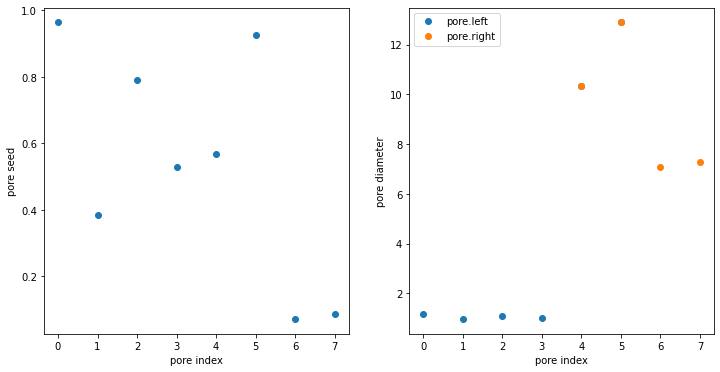

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=[12, 6])

ax[0].plot(pn.Ps, pn['pore.seed'], 'o')
ax[0].set_ylabel('pore seed')
ax[0].set_xlabel('pore index')

ax[1].plot(pn.pores('left'), pn['pore.diameter@left'], 'o', label='pore.left')
ax[1].plot(pn.pores('right'), pn['pore.diameter@right'], 'o', label='pore.right')
ax[1].set_ylabel('pore diameter')
ax[1].set_xlabel('pore index')
ax[1].legend();

And now we can apply a model to the full domain that computes the pore volume, using values of pore diameter that were computed uniquely for each domain:

In [23]:
pn.add_model(propname='pore.volume', 
             model=op.models.geometry.pore_volume.sphere)

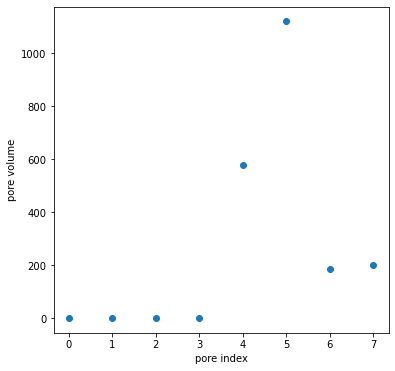

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=[6, 6])

ax.plot(pn.Ps, pn['pore.volume'], 'o')
ax.set_ylabel('pore volume')
ax.set_xlabel('pore index');

### Mixing Many Subdomains of Different Shape
Because subdomains are now very abstract (actually just labels), it is possible to define multiple subdomains with different shape and apply models to each. So far we have added ``'pore.seed'`` and ``'pore.diameter'`` models to the ``'left'`` and ``'right'`` pores.  We can now freely add another set of models to the ``'front'`` and ``'back'``, even though they partially overlap:

In [25]:
Ps = pn.pores(['front', 'back'])
Ts = pn.find_neighbor_throats(Ps, asmask=True)
pn['throat.front'] = Ts
pn['throat.back'] = ~Ts

In [26]:
pn.add_model(propname='throat.diameter', 
             model=op.models.geometry.throat_size.from_neighbor_pores,
             domain='front', 
             mode='min')
pn.add_model(propname='throat.diameter', 
             model=op.models.geometry.throat_size.from_neighbor_pores,
             domain='back',
             mode='max')

Now we can see that the throat diameters have beed added to the network:

In [27]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x23b54e3d130>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         8 / 8
  2  pore.diameter                                                       8 / 8
  3  pore.new_array                                                      5 / 8
  4  pore.seed                                                           8 / 8
  5  pore.values                                                         8 / 8
  6  pore.volume                                                         8 / 8
  7  throat.conns                                                      10 / 10
  8  throat.diameter                                                   10 / 10
――――